Genetic Algorithm for Travelling Salesman Problem

In [1]:
## Import Packages

import numpy as np
import random
from matplotlib import pyplot as plt

In [2]:
## Variables

## Variables that should not be changed
cities = ["Frederick", "Hagerstown", "Germantown", "Shepardstown", "WashingtonDC"]
distance_array = np.array([[0,25.1,21.9,31.7,45.4],[25.1,0,44.9,18,68.6],[21.9,44.9,0,50.7,27.7],[31.7,18,50.7,0,74.4],[45.4,68.6,27.7,74.4,0]])
best_dist = 1000
best_path = []
path_dist = []
# initiate global variable for sub population, build structured array (chromosome, fitness)
dtype=[('chrom', np.ndarray),('fit', np.float32)]
# initialize first chromosome, assign a fitness of 0.0
arr_size = distance_array.shape[0]

## Variables User can change
# Mutation rate (between 0 and 1)
mut_rate = 0.1

# Initial Population size
init_pop_size = 10

# Number of children that will be born 
num_child = 1

# Number of chromosomes that will be killed in each generation (set equal to or lower than number of children to ensure no extinction)
num_kill = 1

# Number of generations simulation will run
num_generations = 150

In [3]:
## Functions Used

def gen_permtx(length):
    # generate positions of non zero integer randomly with no duplicates
    poslist = random.sample(range(length),length)

    # generate length X length numpy array filled with zeros
    blank_nar = np.zeros((length,length), dtype=int)

    # iterate through blank_nar, changing a zero to a one using poslist as position of change at reach row
    for row in range(0,length):
        blank_nar[row,poslist[row]]=1

    return blank_nar

def gen_pop(num):
    global init_pop
    '''
    This function generates a structured array of size "num", that contains a chromosome and fitness score initialized to 0.0.  Calls upon gen_chrom (gc)
    to generate the permutation matrices (chromosome).  Returns the completed sub population containing "num" number of chromosomes. 
    '''    
    # append new (chromosome, fitness) to the sub_pop structured array, will total to "num" number of chromosome-fitness pairs
    # does not check for identical chromosomes, not too concerned with "twins"
    for i in range(num-1):
        init_pop = np.append(init_pop, np.array([(gen_permtx(arr_size), 0.0)], dtype=dtype))
    return init_pop

def fit_func(chrom):
    '''
    This function takes the chromosome and returns the total distance travelled
    '''
    dist = 0
    for row in range(0,arr_size-1):
        # returns position "1" in row
        dis_row = int(np.where(chrom[row]==1)[0])
        dis_col = int(np.where(chrom[row+1]==1)[0])
        dist_int = distance_array[dis_row][dis_col]
        dist += dist_int
    return "{:.1f}".format(dist)

def crossover_genes(chrom1, chrom2):
    '''
    Perform crossver by selecting first and last genes from parents to pass down (first and last cities visited).  Middle 3 genes are selected at random
    '''
    def gen_poslist():
        poslist = random.sample([0,1,2,3,4],3)
        return poslist

    # initialize all fives for child
    child_gene = [5,5,5,5,5]

    # first gene (first city visited) from parent 1 and last gene (last city visited) from parent two will go to child, rest is random
    child_gene[0] = chrom1['chrom'][0].nonzero()[1][0]
    child_gene[4] = chrom2['chrom'][0].nonzero()[1][4]
    if child_gene[0] == child_gene[4]:
        # if the genes are equal, just use first parents 4th gene
        child_gene[4] = chrom1['chrom'][0].nonzero()[1][4]

    # # checks if middle genes exist as first or second gene
    in_chrom = True
    while in_chrom == True:
        ctr = 1
        initposlist = gen_poslist()
        for item in initposlist:
            if item not in child_gene:
                ctr+=1
            else:
                break
        if ctr == 4:
            in_chrom = False

    # adds to child gene
    for i in range(0,3):
        child_gene[i+1] = initposlist[i]

    # builds child chromosome
    blank_child = np.zeros((5,5), dtype=int)
    for row in range(0,5):
        blank_child[row,child_gene[row]]=1
    
    child_chromosome = np.array([(blank_child, fit_func(blank_child))], dtype=dtype)
    
    return child_chromosome

def mate_select(subpop):
    '''
    Performs roulette selection, returns 1 parent for asexual reproduction
    '''
    # create inverse fitnesses
    copy_subpop = np.copy(subpop)
    inv = np.array([])
    for chromosome in subpop:
        inv = np.append(inv, 1/chromosome['fit'])

    # get first positions of the most and least fit
    pos_mostfit =  np.argmax(inv)
    pos_leastfit = np.argmin(inv)

    # Bias selection towards most fit, remove chance of selecting least fit
    inv[pos_mostfit] = inv[pos_mostfit] + inv[pos_leastfit]
    inv[pos_leastfit] = 0.0

    # generate normalized inverses to have highest chance of selecting minimum, assign to chromosome
    suminv = np.sum(inv)
    for i in range(subpop.size):
        # copy_subpop[i]['fit'] = float("{:.4f}".format(inv[i]/suminv))
        copy_subpop[i]['fit'] = inv[i]/suminv

    # select 
    return np.random.choice(subpop, 1, p=copy_subpop['fit'])

def kill_select():
    '''
    Perform roulette selection, least fit is most selected for being killed
    '''
    global live_sub_pop

    # create fitnesses
    copy_subpop = np.copy(live_sub_pop)
    fitlist = []
    for chromosome in copy_subpop:
        fitlist.append(chromosome['fit'])

    # generate normalized fitness
    sums = sum(fitlist)
    for i in range(copy_subpop.size):
        copy_subpop[i]['fit'] = float("{:.8f}".format(fitlist[i]/sums))

    # select one to kill using roulette
    chrom_to_kill = np.random.choice(live_sub_pop, 1, p=copy_subpop['fit'])

    # need to get position since sorting doesn't work on the structured array
    del_pos = 0
    for chrom in live_sub_pop:
        if np.array_equal(chrom,chrom_to_kill[0]):
            break
        del_pos += 1
    
    # now delete
    del_live_sub_pop = np.delete(live_sub_pop, del_pos, 0)
    return del_live_sub_pop

def mutate_gene(rate,chrom):
    mut_int = int(rate*100)
    num_sel = random.randint(0,100)
    
    # if number is less than mutation, swap, if not pass
    if num_sel <= mut_int:
        # select row
        row1 = random.randint(0,arr_size-1)
        row2 = random.randint(0,arr_size-1)
        while row2 == row1:
            row2 = random.randint(0,arr_size-1)

        #swap row in array
        chrom[[row1,row2]] = chrom[[row2,row1]]
    
    return chrom

def calc_best_dist(subpop):
    '''
    Stores best distance, returns current best dist
    '''
    global best_dist
    global best_path
    global path_dist

    for chromosome in subpop:
        if chromosome['fit'] < best_dist:
            temp_path = 0
            best_path.clear()
            best_dist = chromosome['fit']
            temp_path = chromosome['chrom'].nonzero()[1] 
            for visit in temp_path:
                best_path.append(cities[visit])
    
    path_dist.append(best_dist)
    return

Shortest Path: Shepardstown-Hagerstown-Frederick-Germantown-WashingtonDC at 92.7 miles.


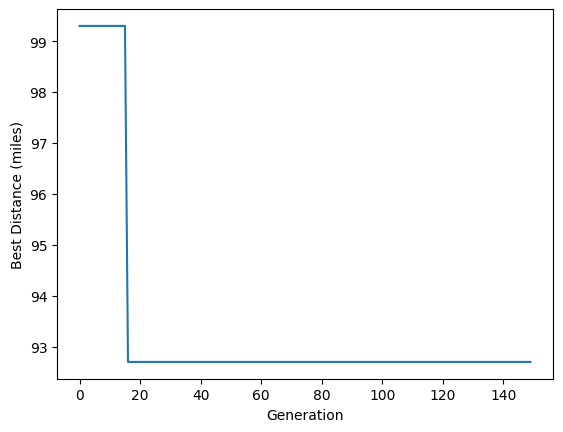

In [4]:
## Genetic Algorithm

# Build initial chromosome
init_pop = np.array([(gen_permtx(5), 0.0)], dtype=dtype)

# Generate population
live_sub_pop = gen_pop(init_pop_size)

# Perform genetic algorithm, stopping at number of set generations
for generation in range(0,num_generations):
    # get fitness for each chromosome
    for fit_i in range(0, live_sub_pop.size):
        live_sub_pop[fit_i]['fit'] = fit_func(live_sub_pop[fit_i]['chrom'])

    # choose who will have child, perform crossover, add child to population
    selected_chromosome1 = np.copy(mate_select(live_sub_pop))
    selected_chromosome2 = np.copy(mate_select(live_sub_pop))
    child = np.copy(crossover_genes(selected_chromosome1, selected_chromosome2))
    child['fit'] = fit_func(child['chrom'][0])
    for child_j in range(num_child):
        live_sub_pop = np.append(live_sub_pop, child)

    # delete least fit
    for kill_k in range(num_kill):
        live_sub_pop = kill_select()

    # go through all in population, apply mutation
    for mut_l in range(0, live_sub_pop.size):
        live_sub_pop[mut_l]['chrom'] = mutate_gene(mut_rate, live_sub_pop[mut_l]['chrom'])

    # update fitness for each chromosome
    for update_m in range(0, live_sub_pop.size):
        live_sub_pop[update_m]['fit'] = fit_func(live_sub_pop[update_m]['chrom'])
    
    # hum_read(live_sub_pop)
    calc_best_dist(live_sub_pop)

## Print out graph and best path with best distance
print("Shortest Path:", "-".join(best_path), "at", best_dist, "miles.")
plt.plot(path_dist)
plt.xlabel("Generation")
plt.ylabel("Best Distance (miles)")
plt.show()